# 硬件环境
- 100G硬盘

# 软件环境
- pytorch, ffmpeg, ffprobe

# 比赛读取文件路径如下

其中`query`和`refer`是比赛压缩包解压后的文件夹。
`query_frame`和`refer_frame`是抽取关键帧存储的文件夹。

In [4]:
! mkdir ../input/query_frame ../input/refer_frame
! ls  -l ../input/

total 48526960
drwxrwxr-x    2 1000 1000      258048 Aug  8 19:06 query
drwxr-xr-x 4502 root root      217088 Aug 25 12:09 query_frame
drwxrwxrwx    2 root root        8192 Aug  8 18:49 refer
drwxr-xr-x  207 root root        8192 Aug 25 12:57 refer_frame
-rw-r--r--    1 root root      100560 Aug 24 16:15 submit_example.csv
-rw-r--r--    1 root root  5318550677 Aug 23 21:33 test_query.tar.gz
-rw-r--r--    1 root root      223793 Aug 24 16:15 train.csv
-rw-r--r--    1 root root 10461833265 Aug 23 22:14 train_query.tar.gz
-rw-r--r--    1 root root 33910238789 Aug 24 00:29 train_refer.tar.gz


In [5]:
import os
import sys
import glob
import shutil
import codecs
import subprocess

import pandas as pd
import numpy as np
import time

%pylab inline
from PIL import Image
train_df = pd.read_csv('../input/train.csv')

from multiprocessing.pool import ThreadPool

Populating the interactive namespace from numpy and matplotlib


In [2]:
query_id = glob.glob('../input/query/*.mp4')
refer_id = glob.glob('../input/refer/*.mp4')

In [3]:
# 抽取关键帧
def extract_keyframe(id):
    if id.split('/')[-2] == 'query':
        query_id = id.split('/')[-1][:-4]
        query_mp4 = '../input/query/' + query_id + '.mp4'
    
        if not os.path.exists('../input/query_frame/'+query_id):
            os.mkdir('../input/query_frame/'+query_id)    
        
        
        command = ['ffmpeg', '-i', query_mp4,
                   '-vf', '"select=eq(pict_type\,I)"', 
                   ' -vsync', 'vfr', '-qscale:v', '2',
                   '-f', 'image2', 
                   '../input/query_frame/{0}/{0}_%05d.jpg'.format(query_id)]
        # 抽取关键帧
        os.system(' '.join(command))
        
        command = 'ffprobe -i {0} -v quiet -select_streams v -show_entries frame=pkt_pts_time,pict_type|grep -B 1 pict_type=I|grep pkt_pts_time > {1}'
        # 抽取视频关键帧时间
        os.system(command.format(query_mp4, '../input/query_frame/{0}/{0}.log'.format(query_id)))
    else:
        refer_id = id.split('/')[-1][:-4]
        refer_mp4 = '../input/refer/' + refer_id + '.mp4'
        
        if not os.path.exists('../input/refer_frame/'+refer_id):
            os.mkdir('../input/refer_frame/'+refer_id)
            
        command = ['ffmpeg', '-i', refer_mp4,
                   '-vf', '"select=eq(pict_type\,I)"', 
                   ' -vsync', 'vfr', '-qscale:v', '2',
                   '-f', 'image2', 
                   '../input/refer_frame/{0}/{0}_%05d.jpg'.format(refer_id)]
        # 抽取关键帧
        os.system(' '.join(command))
        
        command = 'ffprobe -i {0} -v quiet -select_streams v -show_entries frame=pkt_pts_time,pict_type|grep -B 1 pict_type=I|grep pkt_pts_time > {1}'
        # 抽取视频关键帧时间
        os.system(command.format(refer_mp4, '../input/refer_frame/{0}/{0}.log'.format(refer_id)))

In [4]:
# 并行抽取，40是机器核数量
ThreadPool(40).imap_unordered(extract_keyframe, query_id[:])

In [22]:
# 并行抽取，40是机器核数量
ThreadPool(40).imap_unordered(extract_keyframe, refer_id[:])

In [6]:
# 将关键帧使用时间戳从新命名
for id in query_id[:]:
    id_files = glob.glob('../input/query_frame/'+id.split('/')[-1][:-4]+'/*.jpg')
    id_times = codecs.open('../input/query_frame/{0}/{0}.log'.format(id.split('/')[-1][:-4])).readlines()
    id_times = [x.strip().split('=')[1] for x in id_times]
    
    for id_file, id_time in zip(id_files, id_times):
        shutil.move(id_file, id_file[:-9]+id_time.zfill(15)+'.jpg')

In [23]:
# 将关键帧使用时间戳从新命名
for id in refer_id[:]:
    id_files = glob.glob('../input/refer_frame/'+id.split('/')[-1][:-4]+'/*.jpg')
    id_times = codecs.open('../input/refer_frame/{0}/{0}.log'.format(id.split('/')[-1][:-4])).readlines()
    id_times = [x.strip().split('=')[1] for x in id_times]
    
    for id_file, id_time in zip(id_files, id_times):
        shutil.move(id_file, id_file[:-9]+id_time.zfill(15)+'.jpg')

In [53]:
# 读取query视频的关键帧，并按照视频和关键帧时间进行排序
query_imgs_path = []
for id in pd.read_csv('../input/submit_example.csv')['query_id']:
    query_imgs_path += glob.glob('../input/query_frame/' + id + '/*.jpg')
query_imgs_path.sort(key=lambda x: x.lower())

In [38]:
# 读取refer视频的关键帧，并按照视频和关键帧时间进行排序

refer_imgs_path = glob.glob('../input/refer_frame/*/*.jpg')
refer_imgs_path.sort(key=lambda x: x.lower())

In [14]:
import cv2
import imagehash
from PIL import Image
from tqdm import tqdm_notebook
from scipy.spatial.distance import cosine

def compute_cosin_distance(Q, feats, names):
    """
    feats and Q: L2-normalize, n*d
    """
    dists = np.dot(Q, feats.T)
    idxs = np.argsort(dists)[::-1]
    rank_dists = dists[idxs]
    rank_names = [names[k] for k in idxs]
    return idxs, rank_dists, rank_names

def hamming_distance(chaine1, chaine2):
    return sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))

In [39]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import logging
logging.basicConfig(level=logging.DEBUG, filename='example.log',
                    format='%(asctime)s - %(filename)s[line:%(lineno)d]: %(message)s')  # 

class QRDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        print(self.img_path)
        self.img_label = np.zeros(len(img_path))
    
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, self.img_path[index]

    def __len__(self):
        return len(self.img_path)
    
model = models.resnet18(True).cuda()

def predit_file(path):
    if not isinstance(path, list):
        path = [path]
    
    # print(path)
    
    data_loader = torch.utils.data.DataLoader(
        QRDataset(path, 
                transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        ), batch_size=40, shuffle=False, num_workers=10,
    )
    
    img_feat = []
    with torch.no_grad():
        for batch_data in tqdm_notebook(data_loader):
            batch_x, batch_y = batch_data
            
            # print(batch_y[:10])
            batch_x = Variable(batch_x).cuda()
            feat_pred = model(batch_x)

            # max-pooling
            # feat_pred = F.max_pool2d(feat_pred, kernel_size=(24, 32))
            
            # ave-pooling
            # feat_pred = F.avg_pool2d(feat_pred, kernel_size=(24, 32))[:, :, 0, 0]
            
            #print(feat_pred.shape, batch_x.shape)
            feat_pred = feat_pred.data.cpu().numpy()
            # feat_pred = feat_pred.max(-1).max(-1)
            
            # feat_pred = feat_pred.reshape((-1, 512))
            img_feat.append(feat_pred)
            
            del feat_pred
            # img_feat.append(feat_pred)
            
    img_feat = np.vstack(img_feat)
    return img_feat

In [55]:
# 抽取query关键帧特征
query_cnn = predit_file(list(query_imgs_path[:]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
# 抽取refer关键帧特征
refer_cnn = predit_file(list(refer_imgs_path[:]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
# -*- coding: utf-8 -*-
import os, sys, codecs
import glob

import numpy as np
import cv2

from sklearn.preprocessing import normalize as sknormalize
from sklearn.decomposition import PCA

def normalize(x, copy=False):
    """
    A helper function that wraps the function of the same name in sklearn.
    This helper handles the case of a single column vector.
    """
    if type(x) == np.ndarray and len(x.shape) == 1:
        return np.squeeze(sknormalize(x.reshape(1,-1), copy=copy))
        #return np.squeeze(x / np.sqrt((x ** 2).sum(-1))[..., np.newaxis])
    else:
        return sknormalize(x, copy=copy)
        #return x / np.sqrt((x ** 2).sum(-1))[..., np.newaxis]

# 特征归一化
query_cnn = normalize(query_cnn)
refer_cnn = normalize(refer_cnn)

# 计算相似关键帧

这一步只能计算得到关键帧相似结果，但具体的视频时间段还需要进一步对齐（TODO）。

In [57]:
path_flag = [0]
for idx, (path, feat) in enumerate(zip(query_imgs_path, query_cnn)):
    idxs, rank_dists, rank_names = compute_cosin_distance(feat, refer_cnn, refer_imgs_path)
    if rank_dists[0] > 0.9:
        # if hamming_distance(refer_hash[idxs[0]], query_hash[idx]) < 5:
        
        if path.split('/')[-2] != path_flag[-1]:
            print('')
        
        print(path.split('/')[-1], rank_names[0].split('/')[-1])
        path_flag.append(path.split('/')[-2])


016cf7e8-b8d6-11e9-930e-fa163ee49799_00000031.500000.jpg 1293733400_00000586.520000.jpg
016cf7e8-b8d6-11e9-930e-fa163ee49799_00000061.900000.jpg 1293733400_00000616.920000.jpg
016cf7e8-b8d6-11e9-930e-fa163ee49799_00000073.200000.jpg 1293733400_00000628.280000.jpg
016cf7e8-b8d6-11e9-930e-fa163ee49799_00000078.600000.jpg 1293733400_00000633.680000.jpg

03031510-b8d1-11e9-930e-fa163ee49799_00000049.600000.jpg 1260706600_00000496.480000.jpg

0367233c-b874-11e9-b45b-fa163ee49799_00000002.466667.jpg 2801578300_00001385.440000.jpg
0367233c-b874-11e9-b45b-fa163ee49799_00000004.933333.jpg 2801578300_00001387.920000.jpg
0367233c-b874-11e9-b45b-fa163ee49799_00000079.200000.jpg 2801578300_00001462.200000.jpg

03b98950-b929-11e9-b8ed-fa163e063a2b_00000022.400000.jpg 1598981800_00000574.840000.jpg

041134d8-b989-11e9-b8ed-fa163e063a2b_00000058.133333.jpg 1601278800_00005860.280000.jpg

07b833d0-b910-11e9-81a2-fa163e3d9e3c_00000065.866667.jpg 1773350800_00001538.080000.jpg
07b833d0-b910-11e9-81a2-fa

KeyboardInterrupt: 

# 结果提交

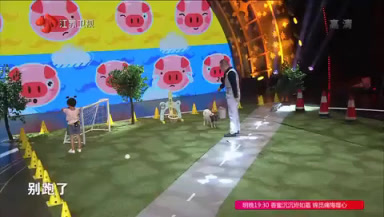

In [6]:
Image.open('../input/query_frame/016cf7e8-b8d6-11e9-930e-fa163ee49799/016cf7e8-b8d6-11e9-930e-fa163ee49799_00000031.500000.jpg')

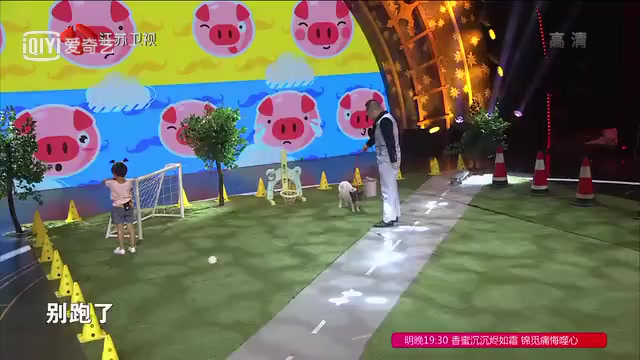

In [8]:
Image.open('../input/refer_frame/1293733400/1293733400_00000586.520000.jpg')

In [9]:
# 提交一个最简单的结果。
submit_df = pd.read_csv('../input/submit_example.csv')
submit_df.loc[submit_df['query_id'] == '016cf7e8-b8d6-11e9-930e-fa163ee49799', 
              ['query_time_range(ms)', 'refer_id', 'refer_time_range(ms)']] = ['0|80500', '1293733400', '554000|635000']
submit_df.to_csv('result.csv', index=None, sep=',')